<a href="https://colab.research.google.com/github/HanifFaishalH/Kuis2_KlasifikasiJenisBatik/blob/main/Kuis2_Batik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
!git pull https://github.com/HanifFaishalH/Kuis2_KlasifikasiJenisBatik.git

fatal: not a git repository (or any of the parent directories): .git


# 1. Preprocessing Data Batik

augmentasi data > 1 gambar menjadi 4 gambar (1 gambar asli + 3 gambar hasil augmentasi)
Image enhancement → contras/brightness correction, noise removal, glare removal, etc.

In [27]:
!pip install albumentations==1.3.1 opencv-python tqdm

import cv2
import numpy as np
import albumentations as A
from pathlib import Path
from google.colab import files
from tqdm import tqdm

input_folder = ('/content/drive/MyDrive/batik_dataset/batik-augmentasi')
output_folder = ('/content/drive/MyDrive/batik_dataset/batik_aug')
copies_per_image = 3
img_size = 512

Path(output_folder).mkdir(parents=True, exist_ok=True)

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.7),
    A.Rotate(limit=30, p=0.5),
])

image_files = sorted([
    p for p in Path(input_folder).glob("*")
    if p.suffix.lower() in [".jpg", ".jpeg", ".png"]
])

print(f"Total gambar batik-cap ditemukan: {len(image_files)}")
print(f"Memulai augmentasi (Total output: {len(image_files) * (copies_per_image + 1)} gambar)...")

for img_path in tqdm(image_files, desc="Augmentasi Gambar"):
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"Gagal membaca: {img_path.name}, skipping.")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    base_name = img_path.stem

    original_resized = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
    save_path_original = Path(output_folder) / f"{base_name}_original.jpg"
    cv2.imwrite(str(save_path_original), cv2.cvtColor(original_resized, cv2.COLOR_RGB2BGR))

    for i in range(copies_per_image):
        aug = transform(image=img)
        aug_img = aug["image"]

        if aug_img.dtype != np.uint8:
            aug_img = np.clip(aug_img, 0, 255).astype(np.uint8)

        aug_img = cv2.resize(aug_img, (img_size, img_size), interpolation=cv2.INTER_AREA)

        save_path = Path(output_folder) / f"{base_name}_aug_{i+1:02d}.jpg"
        cv2.imwrite(str(save_path), cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))

print("\nSelesai! Semua gambar batik-cap berhasil di-augment.")
print(f"Total gambar di folder output: {len(list(Path(output_folder).glob('*.jpg')))}")

Total gambar batik-cap ditemukan: 900
Memulai augmentasi (Total output: 3600 gambar)...


Augmentasi Gambar: 100%|██████████| 900/900 [01:37<00:00,  9.24it/s]



Selesai! Semua gambar batik-cap berhasil di-augment.
Total gambar di folder output: 3600


In [28]:
import cv2
import os
import numpy as np
from tqdm import tqdm

input_dir = '/content/drive/MyDrive/batik_dataset/batik_aug'
output_dir = '/content/drive/MyDrive/batik_dataset/batik-enhanced'
os.makedirs(output_dir, exist_ok=True)

def enhance_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None

    # 1. Contrast enhancement (CLAHE)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    enhanced = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    # 2. Brightness normalization
    hsv = cv2.cvtColor(enhanced, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.equalizeHist(v)
    hsv_enhanced = cv2.merge((h, s, v))
    enhanced = cv2.cvtColor(hsv_enhanced, cv2.COLOR_HSV2BGR)

    # 3. Noise removal (bilateral)
    denoised = cv2.bilateralFilter(enhanced, d=9, sigmaColor=75, sigmaSpace=75)

    # 4. Glare removal
    gray = cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
    glare_removed = cv2.inpaint(denoised, mask, 3, cv2.INPAINT_TELEA)

    return glare_removed

print("Melakukan enhancement gambar...")
for filename in tqdm(os.listdir(input_dir)):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)
        enhanced = enhance_image(input_path)
        if enhanced is not None:
            cv2.imwrite(output_path, enhanced)
print("Enhancement selesai! Hasil disimpan di:", output_dir)

Melakukan enhancement gambar...


100%|██████████| 3600/3600 [07:10<00:00,  8.37it/s]

Enhancement selesai! Hasil disimpan di: /content/drive/MyDrive/batik_dataset/batik-enhanced


# 2. Ekstraksi Fitur

Metode ekstraksi fitur yang digunakan terdiri dari tiga jenis, yaitu GLCM, LBP, dan HSV Histogram. Fitur ini diekstraksi dari setiap gambar batik untuk membedakan motif batik (misal parang, kawung, mega mendung, dsb.):

GLCM (Gray Level Co-occurrence Matrix) – menangkap tekstur motif, seperti rapat atau halus, melalui fitur contrast, dissimilarity, homogeneity, energy, correlation.

LBP (Local Binary Pattern) – menangkap pola lokal pada motif, misal garis, titik, atau pola berulang, menggunakan mean dan std histogram LBP.

HSV Histogram – menangkap ciri warna motif, seperti dominasi warna atau gradasi khas motif batik.

In [30]:
import cv2
import os
import numpy as np
import pandas as pd
import re
from tqdm import tqdm
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern

# === Path input dan output ===
input_dir = '/content/drive/MyDrive/batik_dataset/batik-enhanced'  # folder hasil enhancement
label_csv = '/content/drive/MyDrive/batik_dataset/motif_batik_label.csv'
output_csv = '/content/drive/MyDrive/batik_dataset/batik_motif_features.csv'

# === Fungsi ekstraksi fitur citra ===
def extract_features(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # --- GLCM ---
    glcm = graycomatrix(gray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast').mean()
    dissimilarity = graycoprops(glcm, 'dissimilarity').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    energy = graycoprops(glcm, 'energy').mean()
    correlation = graycoprops(glcm, 'correlation').mean()

    # --- LBP ---
    lbp = local_binary_pattern(gray, 8, 1, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 59))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    lbp_mean = hist.mean()
    lbp_std = hist.std()

    # --- HSV ---
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist_h = cv2.calcHist([hsv], [0], None, [8], [0, 180])
    hist_s = cv2.calcHist([hsv], [1], None, [8], [0, 256])
    hist_v = cv2.calcHist([hsv], [2], None, [8], [0, 256])
    color_features = np.concatenate([hist_h, hist_s, hist_v]).flatten()
    color_features /= (color_features.sum() + 1e-7)

    return np.hstack([
        [contrast, dissimilarity, homogeneity, energy, correlation],
        [lbp_mean, lbp_std],
        color_features
    ])

# === Ekstraksi fitur dari semua gambar ===
data = []
filenames = []

print("🔍 Mengekstraksi fitur dari semua citra di folder...")
for file in tqdm(os.listdir(input_dir)):
    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(input_dir, file)
        feats = extract_features(img_path)
        if feats is not None:
            data.append(feats)
            filenames.append(file)

# === Jika tidak ada citra valid ===
if len(data) == 0:
    print("⚠️ Tidak ada citra valid di folder ini! Pastikan input_dir sudah benar.")
else:
    # === Buat DataFrame fitur ===
    columns = [
        'contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation',
        'lbp_mean', 'lbp_std'
    ] + [f'color_{i+1}' for i in range(24)]

    features_df = pd.DataFrame(data, columns=columns)
    features_df['filename'] = filenames

    # === Baca file label hasil deteksi motif ===
    labels_df = pd.read_csv(label_csv)

    # === Fungsi normalisasi nama file ===
    def normalize_filename(name):
        """
        Normalisasi nama agar konsisten:
        - Hapus suffix _aug_01, _original, _orig, dll.
        - Hapus ekstensi (.jpg, .png, dst.)
        - Rapikan underscore ganda.
        """
        name = os.path.basename(name)
        name = re.sub(r'_aug[_-]?\d+', '', name, flags=re.IGNORECASE)
        name = re.sub(r'_original|_orig', '', name, flags=re.IGNORECASE)
        name = re.sub(r'\.jpg|\.jpeg|\.png', '', name, flags=re.IGNORECASE)
        name = re.sub(r'__+', '_', name)
        return name.strip()

    # === Normalisasi nama di kedua dataset ===
    features_df['base_name'] = features_df['filename'].apply(normalize_filename)
    labels_df['base_name'] = labels_df['filename'].apply(normalize_filename)

    # === Debug: tampilkan contoh perbandingan nama ===
    print("\n🧩 Contoh nama setelah normalisasi:")
    print("Fitur :", features_df['base_name'].unique()[:5])
    print("Label :", labels_df['base_name'].unique()[:5])

    # === Merge label ke fitur ===
    merged_df = features_df.merge(labels_df[['base_name', 'motif_batik']],
                                  on='base_name', how='left')
    merged_df.rename(columns={'motif_batik': 'motif_name'}, inplace=True)
    merged_df.drop(columns=['base_name'], inplace=True)

    # === Cek data tanpa label ===
    missing_before = merged_df['motif_name'].isna().sum()
    print(f"\n⚠️ Ada {missing_before} citra tanpa motif_name sebelum perbaikan.")

    # === Fungsi fallback aman untuk isi label yang hilang ===
    def fill_label_safe(row):
        # Jika sudah ada label, kembalikan langsung
        if pd.notna(row['motif_name']):
            return row['motif_name']

        fname = row['filename']
        m = re.match(r'(B\d+_\d+)', fname)
        if not m:
            return np.nan
        key = m.group(1)

        # Coba beberapa strategi pencocokan
        for method, func in [
            ('exact', labels_df['base_name'] == key),
            ('startswith', labels_df['base_name'].str.startswith(key, na=False)),
            ('contains', labels_df['base_name'].str.contains(key, case=False, na=False))
        ]:
            cand = labels_df.loc[func, 'motif_batik']
            if not cand.empty:
                return cand.iloc[0]

        return np.nan  # jika gagal ditemukan

    # Terapkan hanya pada baris yang belum punya label
    merged_df['motif_name'] = merged_df.apply(fill_label_safe, axis=1)

    # === Cek hasil akhir ===
    missing_after = merged_df['motif_name'].isna().sum()
    print(f"✅ Label berhasil diisi. Sebelum: {missing_before} | Sekarang: {missing_after}")

    # Tampilkan contoh jika masih ada yang kosong
    if missing_after > 0:
        print("\nContoh file tanpa label (cek manual):")
        display(merged_df[merged_df['motif_name'].isna()][['filename']].head(10))

    # === Simpan hasil ke CSV ===
    merged_df.to_csv(output_csv, index=False)
    print(f"\n✅ Ekstraksi dan labeling selesai!")
    print(f"📁 File disimpan di: {output_csv}")
    print(f"🖼️ Total citra: {len(merged_df)} | Tanpa label: {missing_after}")

    # Tampilkan contoh hasil akhir
    display(merged_df[['filename', 'motif_name']].head(10))


🔍 Mengekstraksi fitur dari semua citra di folder...


100%|██████████| 3600/3600 [08:38<00:00,  6.94it/s]



🧩 Contoh nama setelah normalisasi:
Fitur : ['B10_1' 'B10_2' 'B10_3' 'B10_4' 'B10_5']
Label : ['B1_1' 'B2_1' 'B3_1' 'B4_1' 'B5_1']

⚠️ Ada 3000 citra tanpa motif_name sebelum perbaikan.
✅ Label berhasil diisi. Sebelum: 3000 | Sekarang: 3000

Contoh file tanpa label (cek manual):


,filename
12,B10_2_aug_01_original.jpg
13,B10_2_aug_01_aug_01.jpg
14,B10_2_aug_01_aug_02.jpg
15,B10_2_aug_01_aug_03.jpg
16,B10_2_aug_02_original.jpg
17,B10_2_aug_02_aug_01.jpg
18,B10_2_aug_02_aug_02.jpg
19,B10_2_aug_02_aug_03.jpg
20,B10_2_aug_03_original.jpg
21,B10_2_aug_03_aug_01.jpg



✅ Ekstraksi dan labeling selesai!
📁 File disimpan di: /content/drive/MyDrive/batik_dataset/batik_motif_features.csv
🖼️ Total citra: 3600 | Tanpa label: 3000


,filename,motif_name
0,B10_1_aug_01_original.jpg,Mega Mendung
1,B10_1_aug_01_aug_01.jpg,Mega Mendung
2,B10_1_aug_01_aug_02.jpg,Mega Mendung
3,B10_1_aug_01_aug_03.jpg,Mega Mendung
4,B10_1_aug_02_original.jpg,Mega Mendung
5,B10_1_aug_02_aug_01.jpg,Mega Mendung
6,B10_1_aug_02_aug_02.jpg,Mega Mendung
7,B10_1_aug_02_aug_03.jpg,Mega Mendung
8,B10_1_aug_03_original.jpg,Mega Mendung
9,B10_1_aug_03_aug_01.jpg,Mega Mendung


## Reduksi Dimensi dengan PCA

📂 Data awal:
     contrast  dissimilarity  homogeneity    energy  correlation  lbp_mean  \
0  248.492469       9.533320     0.176762  0.014148     0.963178  0.017241   
1  242.167355       9.423784     0.178346  0.014183     0.964122  0.017241   
2  248.821862       9.537146     0.176625  0.014153     0.963140  0.017241   
3  250.454172       9.569817     0.176020  0.014118     0.962902  0.017241   
4  440.996150      12.658601     0.149248  0.012670     0.935951  0.017241   

    lbp_std   color_1   color_2   color_3  ...  color_17  color_18  color_19  \
0  0.063380  0.327961  0.000492  0.000061  ...  0.033110  0.044833  0.046363   
1  0.064205  0.328014  0.000579  0.000061  ...  0.032914  0.045015  0.046552   
2  0.063395  0.327930  0.000523  0.000055  ...  0.033077  0.044904  0.046415   
3  0.062659  0.328126  0.000472  0.000071  ...  0.033040  0.044947  0.046403   
4  0.058741  0.328299  0.000512  0.000032  ...  0.030732  0.046349  0.047469   

   color_20  color_21  color_22  colo

/tmp/ipython-input-3890416029.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_labels))
/tmp/ipython-input-3890416029.py:84: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


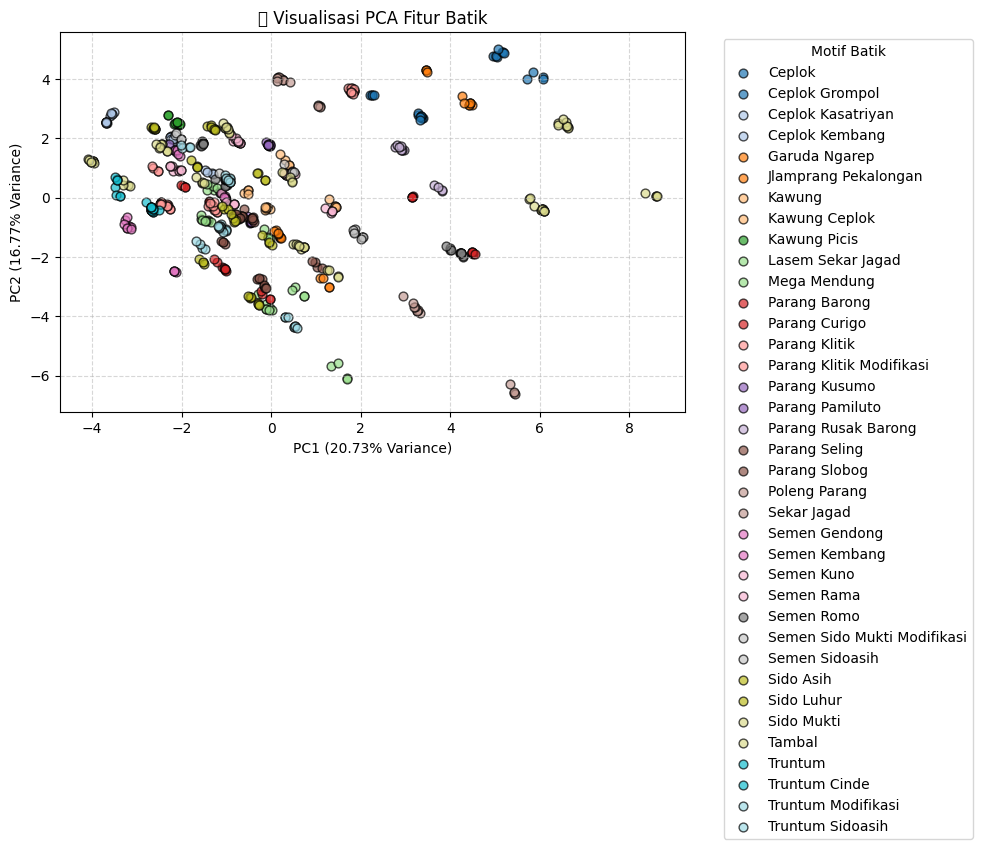

In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# === Path file CSV hasil ekstraksi fitur ===
csv_path = '/content/drive/MyDrive/batik_dataset/batik_motif_features.csv'

# === Baca dataset ===
df = pd.read_csv(csv_path)
print("📂 Data awal:")
print(df.head())

# === Cek missing values ===
missing = df.isnull().sum()
if missing.sum() > 0:
    print("\n⚠️ Data mengandung nilai kosong, akan diisi dengan rata-rata kolom.")
    df = df.fillna(df.mode(numeric_only=True))
else:
    print("\n✅ Tidak ada nilai kosong.")

# === Pisahkan kolom non-fitur (misalnya filename dan motif_name) ===
non_feature_cols = [col for col in df.columns if not col.startswith((
    'contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'lbp_', 'color_'
))]
print(f"\nKolom non-fitur yang diabaikan: {non_feature_cols}")

# === Ambil fitur numerik untuk PCA ===
X = df.drop(columns=non_feature_cols, errors='ignore')
print(f"🔢 Jumlah fitur yang digunakan: {X.shape[1]}")

# === Ambil label (jika ada) ===
y = df['motif_name'] if 'motif_name' in df.columns else None

# === Standarisasi data ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"📊 Data berhasil distandarisasi. Ukuran: {X_scaled.shape}")

# === PCA untuk reduksi dimensi ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("\n📈 Rasio variansi tiap komponen PCA:")
print(f"  PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"  PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"  Total variansi dijelaskan: {sum(pca.explained_variance_ratio_)*100:.2f}%")

# === Visualisasi PCA 2D ===
plt.figure(figsize=(10,7))

if y is not None:
    # Filter out NaN values from y before getting unique labels
    valid_y = y.dropna()
    if not valid_y.empty:
        # Jika ada label, beri warna berdasarkan motif_name
        unique_labels = sorted(valid_y.unique())
        colors = plt.cm.get_cmap('tab20', len(unique_labels))

        for i, label in enumerate(unique_labels):
            plt.scatter(
                X_pca[y == label, 0],
                X_pca[y == label, 1],
                color=colors(i),
                label=label,
                alpha=0.7,
                edgecolor='black',
                s=40
            )
        plt.legend(title='Motif Batik', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        print("\n⚠️ Tidak ada label motif yang valid untuk divisualisasikan.")
        plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, edgecolor='black', s=40)

else:
    # Jika tidak ada label
    plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, edgecolor='black', s=40)

plt.title('🔹 Visualisasi PCA Fitur Batik')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

3. Pembuatan data latih dan data uji
    - Melakukan metode split,
        - 70:30
        - 80:20
        - 90:10
        - Cross-validation dengan k=5

Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import pandas as pd, numpy as np


y = df['motif_id']

models = {
      "SVM_linear": SVC(kernel='linear'),
      "SVM_poly": SVC(kernel='poly'),
      "SVM_rbf": SVC(kernel='rbf'),
      "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
      "Naive Bayes": GaussianNB()
  }

ratios = [0.3, 0.2, 0.1]
ratio_names = ["70:30", "80:20", "90:10"]

result = []
for ratio, ratio_names in zip(ratios, ratio_names):
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=ratio, random_state=42, stratify=y
    )

    row = [ratio_names]
    for m in models.values():
      m.fit(X_train, y_train)
      y_pred = m.predict(X_test)
      row.append(accuracy_score(y_test, y_pred))

    result.append(row)

res_df = pd.DataFrame(
    result,
    columns=["Split"] + list(models.keys())
)
print(res_df)

kf = KFold(n_splits=5,shuffle=True,random_state=42)
cv_results=[]
for name, model in models.items():
    scores = cross_val_score(model,X_scaled,y,cv=kf)
    cv_results.append([name,np.mean(scores),np.std(scores)])

cv_df = pd.DataFrame(cv_results, columns=["Model","Mean Accuracy","Std Dev"])
print(cv_df)